# Data Preparation

In [2]:
#menghubungkan google colab dengan google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Membaca dataset yang disimpan di google drive dalam bentuk data frame
import pandas as pd
file_path = "/content/drive/MyDrive/Dataset/dataset_kenyamanan_ruang_tidur.xlsx" #sesuaikan dengan alamat direktori dataset Anda.
dataset = pd.read_excel(file_path)
dataset = pd.DataFrame(dataset)

In [4]:
dataset.head()

,lux,suara,tempereture,humidity,co2,cuaca,panjang,lebar,Cluster
0,25,64,30.8,83,847,5,4,4,0
1,42,50,30.8,71,621,1,3,3,1
2,25,60,30.8,83,843,2,3,4,0
3,25,52,30.8,83,919,5,3,3,0
4,25,62,30.8,83,801,2,4,4,0


In [5]:
# Cek jumlah baris duplikat
duplicate_rows = dataset.duplicated().sum()
print(f"Jumlah baris duplikat dalam data_set: {duplicate_rows}")

# Jika ingin melihat baris duplikatnya
display(dataset[dataset.duplicated()])

Jumlah baris duplikat dalam data_set: 0


,lux,suara,tempereture,humidity,co2,cuaca,panjang,lebar,Cluster


# Training Model Algoritma

In [6]:
#Libray yang digunakan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
import joblib

In [7]:
# Shuffle dataset
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Pisahkan fitur & target
X = dataset.drop(columns=['Cluster'])
y = dataset['Cluster']

In [8]:
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
# ===== Decision Tree =====
model_dt = DecisionTreeClassifier(max_depth=5, random_state=42)
y_pred_dt = cross_val_predict(model_dt, X_scaled, y, cv=skf)
y_prob_dt = cross_val_predict(model_dt, X_scaled, y, cv=skf, method="predict_proba")[:, 1]
model_dt.fit(X_scaled, y)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [10]:
# ===== Logistic Regression =====
model_lr = LogisticRegression(max_iter=1000, C=0.5, random_state=42)
y_pred_lr = cross_val_predict(model_lr, X_scaled, y, cv=skf)
y_prob_lr = cross_val_predict(model_lr, X_scaled, y, cv=skf, method="predict_proba")[:, 1]

model_lr.fit(X_scaled, y)

LogisticRegression(C=0.5, max_iter=1000, random_state=42)

In [11]:
# ===== Random Forest =====
model_rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
y_pred_rf = cross_val_predict(model_rf, X_scaled, y, cv=skf)
y_prob_rf = cross_val_predict(model_rf, X_scaled, y, cv=skf, method="predict_proba")[:, 1]

model_rf.fit(X_scaled, y)

RandomForestClassifier(max_depth=5, random_state=42)

In [12]:
# ===== SVM =====
model_svm = SVC(kernel='rbf', C=0.5, gamma=0.01, probability=True, random_state=42)
y_pred_svm = cross_val_predict(model_svm, X_scaled, y, cv=skf)
y_prob_svm = cross_val_predict(model_svm, X_scaled, y, cv=skf, method="predict_proba")[:, 1]

model_svm.fit(X_scaled, y)

SVC(C=0.5, gamma=0.01, probability=True, random_state=42)

In [13]:
# ===== KNN =====
model_knn = KNeighborsClassifier(n_neighbors=7)
y_pred_knn = cross_val_predict(model_knn, X_scaled, y, cv=skf)
y_prob_knn = cross_val_predict(model_knn, X_scaled, y, cv=skf, method="predict_proba")[:, 1]

model_knn.fit(X_scaled, y)

KNeighborsClassifier(n_neighbors=7)

In [17]:
# ===== Fungsi evaluasi =====
def evaluate_model(model, X, y, model_name):
    print(f"\n=== Evaluation: {model_name} ===")

    # Prediksi dengan cross-validation
    y_pred = cross_val_predict(model, X, y, cv=skf)
    if hasattr(model, "predict_proba"):
        y_prob = cross_val_predict(model, X, y, cv=skf, method="predict_proba")[:, 1]
    else:  # SVM tanpa probability=False
        y_prob = cross_val_predict(model, X, y, cv=skf, method="decision_function")

    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

    # Deteksi label positif
    if np.issubdtype(np.array(y).dtype, np.number):
        pos_label = 1
        y_true_bin = y
    else:
        pos_label = "Positif"
        y_true_bin = (np.array(y) == "Positif").astype(int)

    # Hitung metrik
    print(f"Accuracy : {accuracy_score(y, y_pred):.4f}")
    print(f"Precision: {precision_score(y, y_pred, pos_label=pos_label, zero_division=0):.4f}")
    print(f"Recall   : {recall_score(y, y_pred, pos_label=pos_label, zero_division=0):.4f}")
    print(f"F1 Score : {f1_score(y, y_pred, pos_label=pos_label, zero_division=0):.4f}")

    try:
        roc_auc = roc_auc_score(y_true_bin, y_prob)
        print(f"ROC AUC  : {roc_auc:.4f}")
    except:
        roc_auc = None
        print("ROC AUC  : Undefined (hanya 1 kelas di y_true)")

    # ===== Plot ROC Curve =====
    if roc_auc is not None:
        fpr, tpr, _ = roc_curve(y_true_bin, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {model_name}")
        plt.legend(loc="lower right")
        plt.show()


=== Evaluation: Logistic Regression ===
Confusion Matrix:
[[576   0]
 [  3 243]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       576
           1       1.00      0.99      0.99       246

    accuracy                           1.00       822
   macro avg       1.00      0.99      1.00       822
weighted avg       1.00      1.00      1.00       822

Accuracy : 0.9964
Precision: 1.0000
Recall   : 0.9878
F1 Score : 0.9939
ROC AUC  : 1.0000


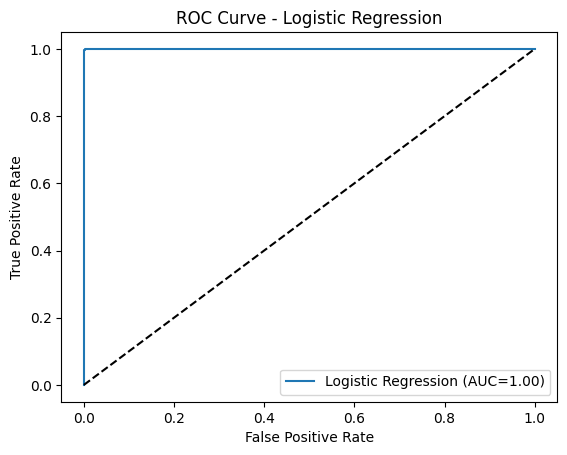


=== Evaluation: Random Forest ===
Confusion Matrix:
[[576   0]
 [  5 241]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       576
           1       1.00      0.98      0.99       246

    accuracy                           0.99       822
   macro avg       1.00      0.99      0.99       822
weighted avg       0.99      0.99      0.99       822

Accuracy : 0.9939
Precision: 1.0000
Recall   : 0.9797
F1 Score : 0.9897
ROC AUC  : 0.9999


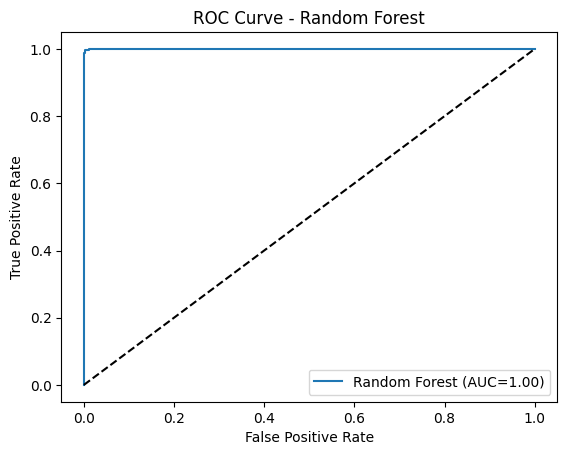


=== Evaluation: SVM (RBF) ===
Confusion Matrix:
[[576   0]
 [  8 238]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       576
           1       1.00      0.97      0.98       246

    accuracy                           0.99       822
   macro avg       0.99      0.98      0.99       822
weighted avg       0.99      0.99      0.99       822

Accuracy : 0.9903
Precision: 1.0000
Recall   : 0.9675
F1 Score : 0.9835
ROC AUC  : 0.9998


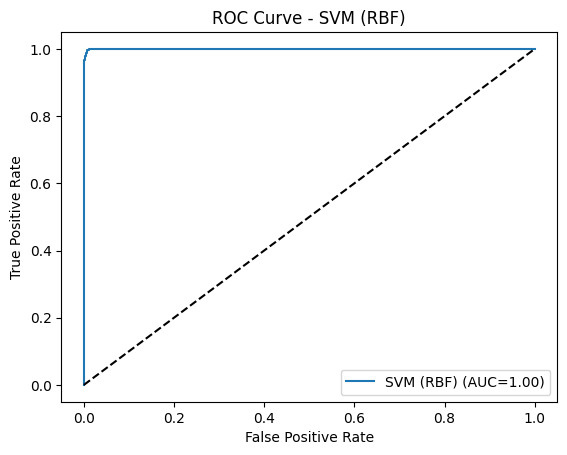


=== Evaluation: KNN ===
Confusion Matrix:
[[573   3]
 [  4 242]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       576
           1       0.99      0.98      0.99       246

    accuracy                           0.99       822
   macro avg       0.99      0.99      0.99       822
weighted avg       0.99      0.99      0.99       822

Accuracy : 0.9915
Precision: 0.9878
Recall   : 0.9837
F1 Score : 0.9857
ROC AUC  : 0.9978


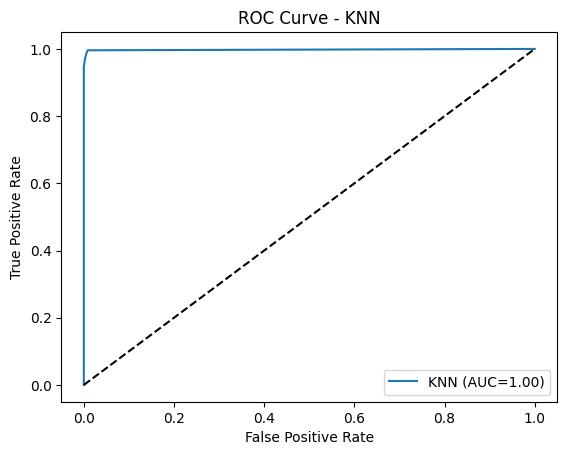


=== Evaluation: Decision Tree ===
Confusion Matrix:
[[573   3]
 [  1 245]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       576
           1       0.99      1.00      0.99       246

    accuracy                           1.00       822
   macro avg       0.99      1.00      0.99       822
weighted avg       1.00      1.00      1.00       822

Accuracy : 0.9951
Precision: 0.9879
Recall   : 0.9959
F1 Score : 0.9919
ROC AUC  : 0.9954


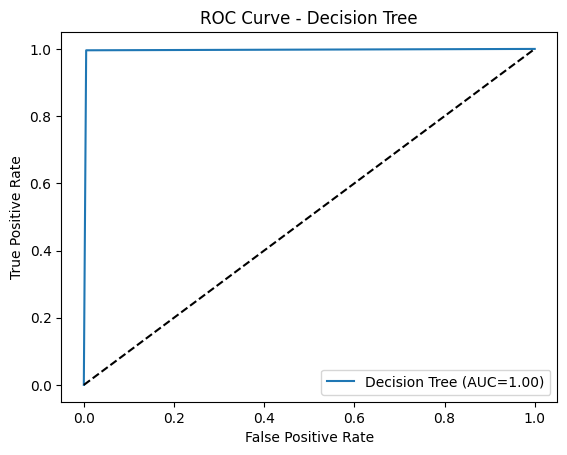

In [18]:
# ===== Evaluasi satu per satu =====
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=0.5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "SVM (RBF)": SVC(kernel="rbf", C=0.5, gamma=0.01, probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42)
}

for name, model in models.items():
    evaluate_model(model, X_scaled, y, name)

In [19]:
# ===== Simpan model dan scaler =====
joblib.dump(scaler, "scaler_all_models.pkl")
#direktori dapat disesuaikan dengan google drive Anda
joblib.dump(model_lr, "/content/drive/MyDrive/Model Buku AIoT/LR_model.pkl")
joblib.dump(model_rf, "/content/drive/MyDrive/Model Buku AIoT/RF_model.pkl")
joblib.dump(model_svm, "/content/drive/MyDrive/Model Buku AIoT/SVM_model.pkl")
joblib.dump(model_knn, "/content/drive/MyDrive/Model Buku AIoT/KNN_model.pkl")
joblib.dump(model_dt, "/content/drive/MyDrive/Model Buku AIoT/DT_model.pkl")

print("✅ Semua model dan scaler berhasil disimpan!")

✅ Semua model dan scaler berhasil disimpan!
